# BackPropagation Neural Network

## 1. import packages

In [1]:
import numpy as np
import copy
import pandas as pd
import bpnnUtil
from sklearn import datasets
import os

## 2. Define class BPNN

### Training a BP Neural Network
![BP](./img/0501.png "BP")

1. Randomly initialize (he_initializer or xavier_initializer)
    * $L$: total no. of layers in Network
    * $n_l$: no. of units (not counting bias unit) in layer l
    * $f(\cdot)$: the activation function in unit
    * $W^{(l)} \in \mathbb{R}^{n_l \times n_{l-1}}$: the weight matrix of connection between the $l-1$th and the $l$th layers
    * $\omega_{ij}^{(l)}$: the element of $W^{(l)}$, presents the weight of connection between the $j$th unit in the $l-1$th layer and the $i$th unit in the $l$th layer
    * $b^{(l)} = (b_1^{(l)}, b_2^{(l)}, ..., b_{n_l}^{(l)})^T \in \mathbb{R}^{n_l}$: the bias of connection between the $l-1$th and the $l$th layers
    * $z^{(l)} = (z_1^{(l)}, z_2^{(l)}, ..., z_{n_l}^{(l)})^T \in \mathbb{R}^{n_l}$: the state of units in the $l$th layer
    * $a^{(l)} = (a_1^{(l)}, a_2^{(l)}, ..., a_{n_l}^{(l)})^T \in \mathbb{R}^{n_l}$: the output value of the $l$th layer
2. Implement forward propagation (forward_L_layer)
3. Implement code to compute cost function (compute_cost)
4. Implement backpropagation to compute partial derivatives (backward_L_layer)
    * $\delta^{(L)} = -(y - a^{(L)}) \odot f'\left( z^(L) \right)$
    * $\delta^{(l)} = \left( \left(W^{(l+1)} \right)^T\delta^{(l+1)} \right) \odot f'\left( z^(l) \right)$
    * $\frac{\partial E}{\partial W^{(l)}} = \delta^{(l)} \left(a^{(l-1)} \right)^T$
    * $\frac{\partial E}{\partial b^{(l)}} = \delta^{(l)}$
5. Use gradient descent or advanced optimization method with backpropagation  to try to mininze cost (gd, sgd, adam, etc.)

In [2]:
class BpNN(object):
    def __init__(self, layer_dims_, learning_rate=0.1, seed=16, initializer='he', optimizer='gd'):

        self.layer_dims_ = layer_dims_
        self.learning_rate = learning_rate
        self.seed = seed
        self.initializer = initializer
        self.optimizer = optimizer

    def fit(self, X_, y_, num_epochs=100):
        m, n = X_.shape
        layer_dims_ = copy.deepcopy(self.layer_dims_)
        layer_dims_.insert(0, n)

        if y_.ndim == 1:
            y_ = y_.reshape(-1, 1)

        assert self.initializer in ('he', 'xavier')

        if self.initializer == 'he':
            self.parameters_ = bpnnUtil.he_initializer(layer_dims_, self.seed)
        elif self.initializer == 'xavier':
            self.parameters_ = bpnnUtil.xavier_initializer(layer_dims_, self.seed)

        assert self.optimizer in ('gd', 'sgd', 'adam', 'momentum')
        if self.optimizer == 'gd':
            parameters_, costs = self.optimizer_gd(X_, y_, self.parameters_, num_epochs, self.learning_rate)
        elif self.optimizer == 'sgd':
            parameters_, costs = self.optimizer_sgd(X_, y_, self.parameters_, num_epochs, self.learning_rate, self.seed)
        elif self.optimizer == 'momentum':
            parameters_, costs = self.optimizer_sgd_monment(X_, y_, self.parameters_, beta=0.9, num_epochs=num_epochs,
                                                            learning_rate=self.learning_rate, seed=self.seed)
        elif self.optimizer == 'adam':
            parameters_, costs = self.optimizer_sgd_adam(X_, y_, self.parameters_, beta1=0.9, beta2=0.999, epsilon=1e-7,
                                                         num_epochs=num_epochs, learning_rate=self.learning_rate,
                                                         seed=self.seed)

        self.parameters_ = parameters_
        self.costs = costs

        return self

    def predict(self, X_):
        if not hasattr(self, "parameters_"):
            raise Exception('you have to fit first before predict.')

        a_last, _ = self.forward_L_layer(X_, self.parameters_)
        if a_last.shape[1] == 1:
            predict_ = np.zeros(a_last.shape)
            predict_[a_last>=0.5] = 1
        else:
            predict_ = np.argmax(a_last, axis=1)
        return predict_

    def compute_cost(self, y_hat_, y_):
        if y_.ndim == 1:
            y_ = y_.reshape(-1, 1)
        if y_.shape[1] == 1:
            cost = bpnnUtil.cross_entry_sigmoid(y_hat_, y_)
        else:
            cost = bpnnUtil.cross_entry_softmax(y_hat_, y_)
        return cost

    def backward_one_layer(self, da_, cache_, activation_):
        # 在activation_ 为'softmax'时， da_实际上输入是y_， 并不是
        (a_pre_, w_, b_, z_) = cache_
        m = da_.shape[0]

        assert activation_ in ('sigmoid', 'relu', 'softmax')

        if activation_ == 'sigmoid':
            dz_ = bpnnUtil.sigmoid_backward(da_, z_)
        elif activation_ == 'relu':
            dz_ = bpnnUtil.relu_backward(da_, z_)
        else:
            dz_ = bpnnUtil.softmax_backward(da_, z_)

        dw = np.dot(dz_.T, a_pre_) / m
        db = np.sum(dz_, axis=0, keepdims=True) / m
        da_pre = np.dot(dz_, w_)

        assert dw.shape == w_.shape
        assert db.shape == b_.shape
        assert da_pre.shape == a_pre_.shape

        return da_pre, dw, db

    def backward_L_layer(self, a_last, y_, caches):

        grads = {}
        L = len(caches)

        if y_.ndim == 1:
            y_ = y_.reshape(-1, 1)

        if y_.shape[1] == 1:  # 目标值只有一列表示为二分类
            # 此处计算还存疑，按照公式应该是执行下一公式，但是，该公式效果更好
            da_last = -(y_ / a_last - (1 - y_) / (1 - a_last))
            # da_last =  y_ - a_last
            da_pre_L_1, dwL_, dbL_ = self.backward_one_layer(da_last, caches[L - 1], 'sigmoid')

        else:  # 经过one hot，表示为多分类

            # 在计算softmax的梯度时，可以直接用 dz = a - y可计算出交叉熵损失函数对z的偏导， 所以这里第一个参数输入直接为y_
            da_pre_L_1, dwL_, dbL_ = self.backward_one_layer(y_, caches[L - 1], 'softmax')

        grads['da' + str(L)] = da_pre_L_1
        grads['dW' + str(L)] = dwL_
        grads['db' + str(L)] = dbL_

        for i in range(L - 1, 0, -1):
            da_pre_, dw, db = self.backward_one_layer(grads['da' + str(i + 1)], caches[i - 1], 'relu')

            grads['da' + str(i)] = da_pre_
            grads['dW' + str(i)] = dw
            grads['db' + str(i)] = db

        return grads

    def forward_one_layer(self, a_pre_, w_, b_, activation_):
        z_ = np.dot(a_pre_, w_.T) + b_
        assert activation_ in ('sigmoid', 'relu', 'softmax')

        if activation_ == 'sigmoid':
            a_ = bpnnUtil.sigmoid(z_)
        elif activation_ == 'relu':
            a_ = bpnnUtil.relu(z_)
        else:
            a_ = bpnnUtil.softmax(z_)

        cache_ = (a_pre_, w_, b_, z_)  # 将向前传播过程中产生的数据保存下来，在向后传播过程计算梯度的时候要用上的。
        return a_, cache_

    def forward_L_layer(self, X_, parameters_):
        L_ = int(len(parameters_) / 2)
        caches = []
        a_ = X_
        for i in range(1, L_):
            w_ = parameters_['W' + str(i)]
            b_ = parameters_['b' + str(i)]
            a_pre_ = a_
            a_, cache_ = self.forward_one_layer(a_pre_, w_, b_, 'relu')
            caches.append(cache_)

        w_last = parameters_['W' + str(L_)]
        b_last = parameters_['b' + str(L_)]

        if w_last.shape[0] == 1:
            a_last, cache_ = self.forward_one_layer(a_, w_last, b_last, 'sigmoid')
        else:
            a_last, cache_ = self.forward_one_layer(a_, w_last, b_last, 'softmax')

        caches.append(cache_)
        return a_last, caches

    def optimizer_gd(self, X_, y_, parameters_, num_epochs, learning_rate):
        costs = []
        for i in range(num_epochs):
            a_last, caches = self.forward_L_layer(X_, parameters_)
            grads = self.backward_L_layer(a_last, y_, caches)

            parameters_ = bpnnUtil.update_parameters_with_gd(parameters_, grads, learning_rate)
            cost = self.compute_cost(a_last, y_)

            costs.append(cost)

        return parameters_, costs

    def optimizer_sgd(self, X_, y_, parameters_, num_epochs, learning_rate, seed):
        '''
        sgd中，更新参数步骤和gd是一致的，只不过在计算梯度的时候是用一个样本而已。
        '''
        np.random.seed(seed)
        costs = []
        m_ = X_.shape[0]
        for _ in range(num_epochs):
            random_index = np.random.randint(0, m_)

            a_last, caches = self.forward_L_layer(X_[[random_index], :], parameters_)
            grads = self.backward_L_layer(a_last, y_[[random_index], :], caches)

            parameters_ = bpnnUtil.update_parameters_with_sgd(parameters_, grads, learning_rate)

            a_last_cost, _ = self.forward_L_layer(X_, parameters_)

            cost = self.compute_cost(a_last_cost, y_)

            costs.append(cost)

        return parameters_, costs

    def optimizer_sgd_monment(self, X_, y_, parameters_, beta, num_epochs, learning_rate, seed):
        '''

        :param X_:
        :param y_:
        :param parameters_: 初始化的参数
        :param v_:          梯度的指数加权移动平均数
        :param beta:        冲量大小，
        :param num_epochs:
        :param learning_rate:
        :param seed:
        :return:
        '''
        np.random.seed(seed)
        costs = []
        m_ = X_.shape[0]
        velcoity = bpnnUtil.initialize_velcoity(parameters_)
        for _ in range(num_epochs):
            random_index = np.random.randint(0, m_)

            a_last, caches = self.forward_L_layer(X_[[random_index], :], parameters_)
            grads = self.backward_L_layer(a_last, y_[[random_index], :], caches)

            parameters_, v_ = bpnnUtil.update_parameters_with_sgd_momentum(parameters_, grads, velcoity, beta,
                                                                           learning_rate)
            a_last_cost, _ = self.forward_L_layer(X_, parameters_)
            cost = self.compute_cost(a_last_cost, y_)
            costs.append(cost)

        return parameters_, costs

    def optimizer_sgd_adam(self, X_, y_, parameters_, beta1, beta2, epsilon, num_epochs, learning_rate, seed):
        '''

        :param X_:
        :param y_:
        :param parameters_: 初始化的参数
        :param v_:          梯度的指数加权移动平均数
        :param beta:        冲量大小，
        :param num_epochs:
        :param learning_rate:
        :param seed:
        :return:
        '''
        np.random.seed(seed)
        costs = []
        m_ = X_.shape[0]
        velcoity, square_grad = bpnnUtil.initialize_adam(parameters_)
        for epoch in range(num_epochs):
            random_index = np.random.randint(0, m_)

            a_last, caches = self.forward_L_layer(X_[[random_index], :], parameters_)
            grads = self.backward_L_layer(a_last, y_[[random_index], :], caches)

            parameters_, velcoity, square_grad = bpnnUtil.update_parameters_with_sgd_adam(parameters_, grads, velcoity,
                                                                                          square_grad, epoch + 1,
                                                                                          learning_rate, beta1, beta2,
                                                                                          epsilon)
            a_last_cost, _ = self.forward_L_layer(X_, parameters_)
            cost = self.compute_cost(a_last_cost, y_)
            costs.append(cost)

        return parameters_, costs


## 5.5

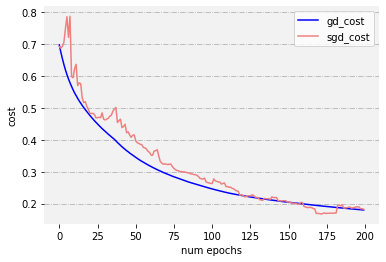

In [4]:
data_path = './data_watermelon/watermelon.data'
data3 = pd.read_csv(data_path, index_col=0)
data = pd.get_dummies(data3, columns=['色泽', '根蒂', '敲声', '纹理', '脐部', '触感'])
data['好瓜'].replace(['是', '否'], [1, 0], inplace=True)
X_test = data.drop('好瓜', axis=1)
y_test = data['好瓜']

bp = BpNN([3, 1], learning_rate=0.1, optimizer='gd')
bp.fit(X_test.values, y_test.values, num_epochs=200)

bp1 = BpNN([3, 1], learning_rate=0.1, optimizer='sgd')
bp1.fit(X_test.values, y_test.values, num_epochs=200)

bpnnUtil.plot_costs([bp.costs, bp1.costs], ['gd_cost', 'sgd_cost'])

## 5.6

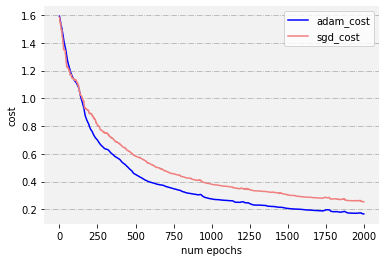

In [5]:
iris = datasets.load_iris()
X = pd.DataFrame(iris['data'], columns=iris['feature_names'])
X = (X - np.mean(X, axis=0)) / np.var(X, axis=0)

y = pd.Series(iris['target_names'][iris['target']])
y = pd.get_dummies(y)

bp = BpNN([3, 3], learning_rate=0.003, optimizer='adam')
bp.fit(X.values, y.values, num_epochs=2000)

bp1 = BpNN([3, 3], learning_rate=0.003, optimizer='sgd')
bp1.fit(X.values, y.values, num_epochs=2000)

bpnnUtil.plot_costs([bp.costs, bp1.costs], ['adam_cost', 'sgd_cost'])